In [1]:
__imp

Libraries have been loaded


### Load Additional Libraries

In [21]:
import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score

basepath = os.path.expanduser('../')

## Load Data

In [4]:
%%time

# contains feature pertaining to raw application file
train = pd.read_pickle('../data/interim/feature_groups/application_train.pkl')
test  = pd.read_pickle('../data/interim/feature_groups/application_test.pkl')

print(train.shape, test.shape)
del train, test
gc.collect();

(307511, 122) (48744, 122)
CPU times: user 46.7 ms, sys: 148 ms, total: 194 ms
Wall time: 2.04 s


In [3]:
%%time

data = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')

CPU times: user 140 ms, sys: 557 ms, total: 697 ms
Wall time: 8.74 s


## Adversarial Validation

In [8]:
%%time

data       = pd.concat((train, test))
data.index = np.arange(len(data))

CPU times: user 107 ms, sys: 32 ms, total: 139 ms
Wall time: 139 ms


In [9]:
for c in data.select_dtypes(include=['category']).columns:
    data[c] = data[c].cat.codes

In [16]:
data['is_test'] = 1
data['is_test'].iloc[:303576] = 0

In [17]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [21]:
params = {
    'objective': 'binary',
    'max_depth': 4,
    'metric': 'auc',
    'nthread': 4,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.947227	eval's auc: 0.947743
[40]	train's auc: 0.954637	eval's auc: 0.955028
[60]	train's auc: 0.959409	eval's auc: 0.959554
[80]	train's auc: 0.963077	eval's auc: 0.96286
[100]	train's auc: 0.965959	eval's auc: 0.965433
[120]	train's auc: 0.96823	eval's auc: 0.967455
[140]	train's auc: 0.969807	eval's auc: 0.968674
[160]	train's auc: 0.971461	eval's auc: 0.970064
[180]	train's auc: 0.972779	eval's auc: 0.971058
[200]	train's auc: 0.973803	eval's auc: 0.971763
[220]	train's auc: 0.974932	eval's auc: 0.972657
[240]	train's auc: 0.975753	eval's auc: 0.973133
[260]	train's auc: 0.976653	eval's auc: 0.973851
[280]	train's auc: 0.9775	eval's auc: 0.974419
[300]	train's auc: 0.978407	eval's auc: 0.975026
[320]	train's auc: 0.979022	eval's auc: 0.975321
[340]	train's auc: 0.979696	eval's auc: 0.975717
[360]	train's auc: 0.980226	eval's auc: 0.975981
[380]	train's auc: 0.980759	eval's auc: 0.976266
[400]	train's 

In [22]:
m.save_model('../data/processed/models/adversarial_model_subset.txt')

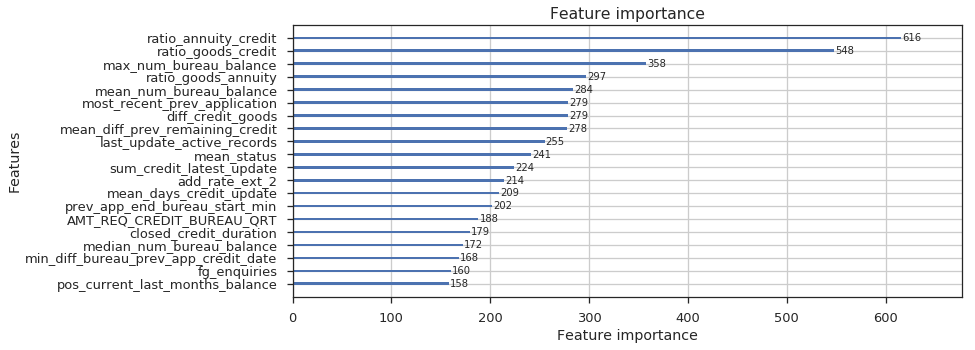

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='split', max_num_features=20, ax=ax);

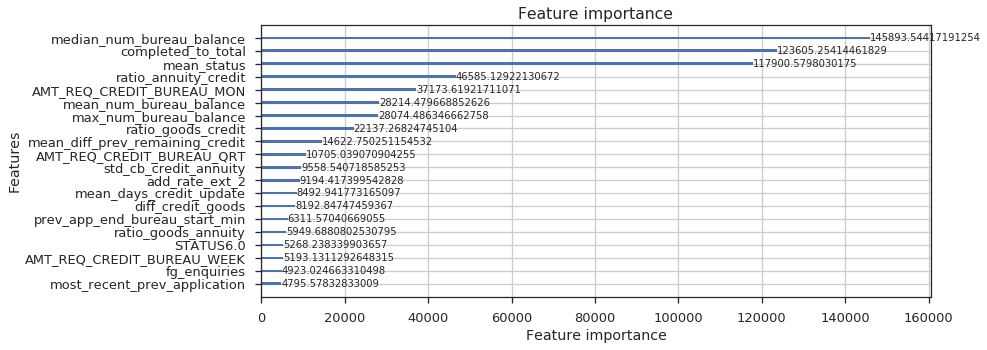

In [24]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='gain', max_num_features=20, ax=ax);

### OOF prediction for training set

In [5]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

data['is_test'] = 1
data['is_test'].iloc[:303576] = 0

data  = data.sample(frac=1.) # shuffle rows
df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [6]:
%%time

estimator  = lgb.LGBMClassifier(n_estimators=2015, max_depth=4, objective='binary')
oof_scores = cross_val_predict(estimator, df, y, cv=5, method='predict_proba')

CPU times: user 2h 51min 43s, sys: 22 s, total: 2h 52min 5s
Wall time: 44min 51s


In [7]:
np.save('../data/processed/models/oof_scores_sub.npy', oof_scores)

In [6]:
oof_scores = np.load('../data/processed/models/oof_scores.npy')

In [8]:
df_copy                        = df.copy()
df_copy.loc[:, 'is_test_prob'] = oof_scores[:, 1]
df_copy.loc[:, 'is_test']      = y
df_copy.loc[:, 'SK_ID_CURR']   = data.SK_ID_CURR

target                         = data.TARGET.iloc[:303576]

In [9]:
del data
gc.collect()

82

In [10]:
df_copy[df_copy.is_test == 0].sort_values(by='is_test_prob', ascending=False)\
                             .loc[:, ['SK_ID_CURR', 'is_test_prob']]

,SK_ID_CURR,is_test_prob
72358,185021,9.999868e-01
131849,254911,9.974637e-01
176317,307008,9.966514e-01
163651,292206,9.949051e-01
252925,396519,9.937778e-01
59929,170445,9.932063e-01
167459,296636,9.931919e-01
107132,225900,9.925747e-01
66538,178204,9.920861e-01
120631,241677,9.918937e-01


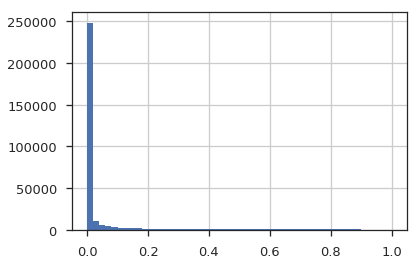

In [11]:
df_copy[df_copy.is_test == 0].is_test_prob.hist(bins=50);

In [77]:
def fold_gen(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .15)]

    for fold in range(5):
        test_index  = list(x.sample(frac=48744).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        yield train_index,  test_index

In [12]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .4)].shape[0]

12798

In [13]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob <= 0.3)].shape[0]

286674

In [24]:
16668 / 307511

0.05420293908185398

In [26]:
.2 * 48744

9748.800000000001

In [20]:
def save_folds(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .3)]
    test_folds = []
    
    for fold in range(6):
        test_index  = list(x.sample(n=9748).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        test_folds.append(test_index)
    
    test_folds = np.array(test_folds).T
    cv_df      = pd.DataFrame(test_folds, columns=[f'F{i}' for i in range(6)])
    
    cv_df.to_csv('../data/raw/cv_adversarial_idx_sub_v1.csv', index=False)
#     return cv_df

In [34]:
save_folds(df_copy)

In [15]:
cv_folds = save_folds(df_copy)

In [16]:
len((set(cv_folds['F0'].values) & set(cv_folds['F2'].values))) / len(cv_folds['F0'])

0.5820681165367255

In [17]:
len((set(cv_folds['F0'].values) & set(cv_folds['F3'].values))) / len(cv_folds['F0'])

0.5770414443988511

In [32]:
len((set(cv_folds['F0'].values) & set(cv_folds['F4'].values))) / len(cv_folds['F0'])

0.5860689372178909

In [18]:
len((set(cv_folds['F0'].values) & set(cv_folds['F1'].values))) / len(cv_folds['F0'])

0.5798112433319655

In [19]:
df_copy.shape

(352321, 710)

In [82]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED
}

num_boost_round       = 500
early_stopping_rounds = 100

ltrain = lgb.Dataset(df.iloc[:len(train)].copy(), TARGET, feature_name=df.columns.tolist())

lgb.cv(params, 
       ltrain, 
       num_boost_round, 
       folds=fold_gen(df_copy), 
       early_stopping_rounds=early_stopping_rounds, 
       verbose_eval=20)

[20]	cv_agg's auc: 0.618144 + 0.00514626
[40]	cv_agg's auc: 0.631824 + 0.0046029
[60]	cv_agg's auc: 0.63968 + 0.00515748
[80]	cv_agg's auc: 0.64062 + 0.00485862
[100]	cv_agg's auc: 0.642104 + 0.00573209
[120]	cv_agg's auc: 0.642286 + 0.00572781
[140]	cv_agg's auc: 0.642618 + 0.00600976
[160]	cv_agg's auc: 0.642657 + 0.00613822
[180]	cv_agg's auc: 0.642169 + 0.0060855
[200]	cv_agg's auc: 0.64151 + 0.00599734
[220]	cv_agg's auc: 0.641801 + 0.0057658
[240]	cv_agg's auc: 0.642513 + 0.00623979
[260]	cv_agg's auc: 0.64221 + 0.00644424


{'auc-mean': [0.6042937582096902,
  0.6063851080102118,
  0.6094948735497355,
  0.6105071593059883,
  0.6103113565861819,
  0.609949146327001,
  0.6112450210864804,
  0.611922664355651,
  0.6130385780092173,
  0.6135514649349239,
  0.6140567851372335,
  0.6138722483547333,
  0.6138905358882123,
  0.6144706221804735,
  0.6154927026924676,
  0.6163287187043333,
  0.616554768416919,
  0.6173352621591126,
  0.6174060247445852,
  0.6181444201569033,
  0.6187143963227383,
  0.6194944579588235,
  0.6198957050849789,
  0.6207915448273522,
  0.6219778419869648,
  0.6230271612099727,
  0.6237795045767934,
  0.6248345699284803,
  0.6255729154444939,
  0.626186580135842,
  0.6268817748326054,
  0.6272010226809934,
  0.6273822084294582,
  0.6275895204726845,
  0.6282070344389259,
  0.6287205101248088,
  0.6293304442291344,
  0.6304520246260321,
  0.6314348211934767,
  0.63182393503278,
  0.6320910920507157,
  0.6328286905792679,
  0.6332499251145899,
  0.6335400030841262,
  0.6339219347473423,
  0.

## Feature Selection

In [5]:
SKIP_FLDS                      = ['SK_ID_CURR', 'TARGET']

df, y                          = data.iloc[:307511].loc[:, data.columns.drop(SKIP_FLDS)], data.iloc[:307511].loc[:, 'TARGET']
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [12]:
params = {
    'objective': 'binary',
    'learning_rate': 0.02,
    'metric': 'auc',
    'max_depth': 6,
    'sub_feature': .05,
    'reg_lambda': 100,
    'num_leaves': 30,
    'min_data_in_leaf': 100,
    'feature_fraction_seed': SEED,
    'min_data_in_leaf': 100,
    'max_bin': 300,
    'reg_lambda': 100,
    'nthread': 4,
    'verbose': -1,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.753514	eval's auc: 0.743248
[40]	train's auc: 0.760975	eval's auc: 0.749357
[60]	train's auc: 0.764638	eval's auc: 0.751588
[80]	train's auc: 0.76911	eval's auc: 0.754965
[100]	train's auc: 0.772924	eval's auc: 0.757673
[120]	train's auc: 0.775898	eval's auc: 0.759636
[140]	train's auc: 0.779077	eval's auc: 0.76191
[160]	train's auc: 0.7821	eval's auc: 0.764041
[180]	train's auc: 0.784601	eval's auc: 0.765846
[200]	train's auc: 0.787142	eval's auc: 0.767497
[220]	train's auc: 0.789478	eval's auc: 0.769111
[240]	train's auc: 0.791481	eval's auc: 0.770514
[260]	train's auc: 0.793569	eval's auc: 0.771994
[280]	train's auc: 0.795471	eval's auc: 0.77316
[300]	train's auc: 0.797254	eval's auc: 0.774265
[320]	train's auc: 0.798912	eval's auc: 0.775219
[340]	train's auc: 0.800393	eval's auc: 0.77598
[360]	train's auc: 0.801907	eval's auc: 0.776758
[380]	train's auc: 0.803453	eval's auc: 0.777704
[400]	train's au

[3320]	train's auc: 0.885139	eval's auc: 0.7928
[3340]	train's auc: 0.885479	eval's auc: 0.792798
[3360]	train's auc: 0.885814	eval's auc: 0.792752
[3380]	train's auc: 0.886105	eval's auc: 0.792733
[3400]	train's auc: 0.886396	eval's auc: 0.792724
Early stopping, best iteration is:
[3302]	train's auc: 0.884891	eval's auc: 0.792815


In [13]:
feat_imp = pd.DataFrame({'feat': m.feature_name(), 'imp': m.feature_importance(importance_type='gain')})\
             .sort_values(by='imp', ascending=False)

In [20]:
feat_imp[feat_imp['imp'] < 43].feat.tolist()

['NAME_GOODS_CATEGORY_6',
 'NAME_EDUCATION_TYPE__2',
 'NAME_HOUSING_TYPE__1',
 'FONDKAPREMONT_MODE',
 'STATUS1.0',
 'FLAG_DOCUMENT_6',
 'num_high_int_no_info_loans',
 'NUM_NULLS_EXT_SCORES',
 'STATUS3.0',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'FLAG_PHONE',
 'NAME_INCOME_TYPE__7',
 'OCCUPATION_TYPE__10',
 'STATUS2.0',
 'OCCUPATION_TYPE__-1',
 'OCCUPATION_TYPE__6',
 'OCCUPATION_TYPE__14',
 'NAME_INCOME_TYPE__1',
 'OCCUPATION_TYPE__3',
 'STATUS5.0',
 'ORGANIZATION_TYPE__31',
 'LIVE_REGION_NOT_WORK_REGION',
 'PRODUCT_COMBINATION_15',
 'FLAG_EMAIL',
 'sum_CODE_GENDER_NAME_EDUCATION_TYPE_OWN_CAR_AGE',
 'OCCUPATION_TYPE__0',
 'REG_REGION_NOT_WORK_REGION',
 'sum_num_times_prolonged',
 'total_cash_credit_dpd',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'ORGANIZATION_TYPE__11',
 'HOUSETYPE_MODE',
 'OCCUPATION_TYPE__8',
 'EMERGENCYSTATE_MODE',
 'ORGANIZATION_TYPE__55',
 'NAME_GOODS_CATEGORY_3',
 'ORGANIZATION_TYPE__33',
 'FLAG_DOCUMENT_5',
 'ORGANIZATION_TYPE__28',
 'ORGANIZATION_TYPE__51',
 'NAME_GOODS_CATEGORY_2

### Shuffle target

In [15]:
SKIP_FLDS                      = ['SK_ID_CURR', 'TARGET']

df, y                          = data.iloc[:307511].loc[:, data.columns.drop(SKIP_FLDS)], data.iloc[:307511].loc[:, 'TARGET']
y = y.sample(frac=1.)
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [16]:
params = {
    'objective': 'binary',
    'learning_rate': 0.02,
    'metric': 'auc',
    'max_depth': 6,
    'sub_feature': .05,
    'reg_lambda': 100,
    'num_leaves': 30,
    'min_data_in_leaf': 100,
    'feature_fraction_seed': SEED,
    'min_data_in_leaf': 100,
    'max_bin': 300,
    'reg_lambda': 100,
    'nthread': 4,
    'verbose': -1,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.620242	eval's auc: 0.504715
[40]	train's auc: 0.643405	eval's auc: 0.507732
[60]	train's auc: 0.659297	eval's auc: 0.506849
[80]	train's auc: 0.669136	eval's auc: 0.50663
[100]	train's auc: 0.677299	eval's auc: 0.50754
Early stopping, best iteration is:
[2]	train's auc: 0.54556	eval's auc: 0.508101


In [17]:
feat_imp_shuffled = pd.DataFrame({
            'feat': m.feature_name(), 
            'imp': m.feature_importance(importance_type='gain')
})\
             .sort_values(by='imp', ascending=False)

In [18]:
feat_imp_shuffled

,feat,imp
26,DAYS_REGISTRATION,42.132000
229,latest_credit,27.934580
175,phone_to_birth_ratio,24.029550
285,mean_last_decision,21.535850
565,diff_education_occupation_source_3_mean,21.534780
317,var_pos_installments_left,20.391211
557,diff_income_type_education_type_source_2_mean,19.343680
158,ratio_annuity_score_1,13.551420
580,mean_OCCUPATION_TYPE_EXT_SOURCE_2,13.188700
262,min_credit_goods_price_bureau,12.960310
